# Individual Assignment: Image Classification with SciKit-Learn


This notebook promises to elaborate on Image Classification pursuing some basic principles for building a classifier for images based on course content visited until session 3. Along preliminary feature engineering and essential transformations, throughout the pipeline our classifier will distinguish between categories: `automobiles`, `planes`, and `trains`, as we are working with VOC dataset.  <br> <br/>

### Classification Problem
This is typically a supervised learning process in which we provide images with pertaining class (labels) to the ML model so that it learns how to distinguish each image. Our problem is rather hard since there are plenty of vehicles, what is more even some machinery module may look like a vehichel or a long modern train is hard to distinguish even for us humans, when a plane is not flying on sky for instance.<br> <br/>


In [0]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install mahotas

In [0]:
# load necessary libraries
from matplotlib import pyplot
import matplotlib.pyplot as plt
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from skimage.feature import hog
import numpy as np
import mahotas
import cv2
import os
import h5py
import imutils
from skimage import exposure
from skimage import feature
from skimage.feature import local_binary_pattern
from scipy.stats import itemfreq
from sklearn.pipeline import Pipeline
from sklearn import metrics
from scipy import ndimage
import skimage.color as sc
import glob
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.externals import joblib
from sklearn.linear_model import SGDClassifier
from skimage.segmentation import slic
from skimage.color import label2rgb

First step is to deal with dataset to handle basic pre-processing. Here what we are applying, is resizing image which is crucial and labelling them based  on their class which is acquired from subfolders of voc dataset. <br> 
In the following parts, data preparating in line with Session2 are defined through functions.

In [0]:
def prep_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects

    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root,d, f)
                img = plt.imread(imgFile)
                # Since the images are different sizes, it requires resizing step
                img = resize(img, (256, 256), anti_aliasing=True)
                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn (we could use flatten method instead
                # of ravel
                # - and add it to the list of features
                features.append(img.ravel())
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id )
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    return features, labels, classnames

# The images are in a folder named 'shapes/training'
training_folder_name = '/content/drive/My Drive/Colab Notebooks/ComputerVision/Notebooks/Individual Assignment/data/voc'

# Prepare the image data
features, labels, classnames = prep_data(training_folder_name)
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)

Reading data from automobile
Reading data from plane
Reading data from train
240 features
240 labels
3 classes: ['automobile', 'plane', 'train']


Let's verify the shapes of the arrays -  we should have a two-dimensional array of features (each image is itself an array), and one dimensional array of labels (each label is an integer value).

In [0]:
print('Feature Shape:',features.shape)
print('Labels Shape:',labels.shape)

Feature Shape: (240, 196608)
Labels Shape: (240,)


### Split the data
Now that the image data is prepared, we can split it into training (70%) and test (30%) subsets:

In [0]:
# split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.25)

print('Training records:',Y_train.size)
print('Test records:',Y_test.size)

Training records: 180
Test records: 60


## Train the classification model

Now we'll use the prepared image data to train a model.

In this case, we'll define a pipeline that contains two steps:
1. Normalize the pixel values so that they are scaled between 0 and 1 - this can prevent high pixel density values from dominating the model training.
2. Train the model using a *Decision Tree* algorithm for classification 


In [0]:
# Convert the training features to floats so they can be scaled
X_train_float = X_train.astype('float64')

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', DecisionTreeClassifier()),
                        ])
# Use the pipeline to fit a model to the training data
clf = img_pipeline.fit(X_train_float, Y_train)

## Evaluate the model
With our model trained, we'll use it to predict labels for the test data and evaluate its precision, recall, and simple accuracy using the known labels. Then we'll plot the confusion matrix to evaluate how well the model performs for each class label.

Classifier Metrics:
              precision    recall  f1-score   support

  automobile       0.52      0.44      0.48        25
       plane       0.33      0.22      0.27        18
       train       0.44      0.71      0.55        17

    accuracy                           0.45        60
   macro avg       0.43      0.46      0.43        60
weighted avg       0.44      0.45      0.43        60

Accuracy: 45.00%

 Confusion Matrix:


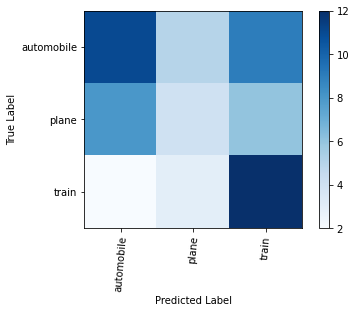

In [0]:
# Evaluate classifier
%matplotlib inline

# Convert the test features for scaling
X_test_float = X_test.astype('float64')

print('Classifier Metrics:')
predictions = clf.predict(X_test)
print(metrics.classification_report(Y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(Y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

With this level of accuracy around 55%, which is unacceptable, it seems that we have way to improve our model. This is even worse than a `random classifier`... Thus, there are some potential in preprocessing and also in model fine tuning, which we are going to explain in following sections.

## It is time to act:

First, for preprocessing let's investigate some features. <br>
 
*   `Image Resizing`: as already applied, in case the sizes of images from train set and the ones from test or future set, this step is essential so that model works properly. <br>
*   `Enhancing Contrast`:  **CLAHE** is implemented the method Contrast Limited Adaptive Histogram Equalization for enhancing the local contrast of an image. <br>
*   `Gaussian Blur`: Image Smoothing techniques help in reducing the noise. Gaussian filters have the properties of having no overshoot to a step function input while minimizing the rise and fall time. In our example, a kernel of *3x3* I picked to be sufficient. <br>
*   `Segmentation`: image segmentation is widely used as a preliminary step for image classification. **SLIC** is an algorithm simply performs K-means in the 5d space of color information and image location.<br><br>

*Note: Canny Edge Detector uses gaussian filter by default, that is why I will not apply this step separately.* <br>
*Note: CLAHE is embedded within another feature extraction function, instead of applying individually.* <br><br>
*Note: At the very end, **edge detector** and **slic segmentation** are cancelled due to lowered accuracies as can be seen __lines which are converted to commentary__.* 




## Further Feature Extraction
Features are the information, corresponding to list of numbers extracted from image. The pixels that we used in the initial attempt seem not that useful. <br> Apparently, the instant ones we can count for vehicles are *Color* and *Shape*. In the following attempt, we will be using: <br>
 
When we consider the entire image, without having interest region: <br>
*   For *Color* - Color Channel Statistics (Mean, Standard Deviation) and `Color Histogram`: To extract Color Histogram features from the image, we use cv2.calcHist(), normalize() and flatten() functions in turn. <br>
*   For *Shape* - `Hu Moments`: calculates all of the moments up to the third order of a polygon or rasterized shape.
*   Others - `Histogram of Oriented Gradients` (HoG): counts occurrences of gradient orientation in localized portions of an image.
*   Others - `SIFT`: scale-invariant feature transform (SIFT) is a feature detection algorithm in computer vision to detect and describe local features in images.<br><br><br>


To **combine extracted feature vectors**, simply concatenation of each feature into a single global feature vector is preferred.<br>
If we were using local features, we would need *Bag of Visual Words*. <br><br>

*Note: although the function is defined in below section, the `SIFT` sophisticated feature cannot be used since its unpaid usage is limited.*







In [0]:
# fixed-sizes for image
fixed_size = tuple((256, 256))

# CLAHE con Uses CLAHE (Contrast Limited Adaptive Histogram Equalization) to increase the contrast of an image. Found on Stack Overflow, written by Jeru Luke.
def increase_contrast(image): 
    # Converting image to LAB Color model
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    # Splitting the LAB image to different channels
    l, a, b = cv2.split(lab)
    # Applying CLAHE to L-channel---
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    # Merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl, a, b))
    # Converting image from LAB Color model to RGB model
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return final
     
classnames = []
# path to training data
train_path = "/content/drive/My Drive/Colab Notebooks/ComputerVision/Notebooks/Individual Assignment/data/voc/"

# bins for histogram
bins = 8

# feature: Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

# feature: Haralick Texture
def fd_haralick(image):
    # enhancing contrast (CLAHE)
    image = increase_contrast(image)
    #segments = slic(image, n_segments=300)
    # Put segments on top of original image to compare
    #segmented_image = label2rgb(segments, image, kind='avg')
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick

# feature: Color Histogram
def fd_histogram(image, mask=None):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()

# feature: SIFT 
def gen_sift_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    # desc is the SIFT descriptors, they're 128-dimensional vectors
    # that we can use for our final features
    kp, desc = sift.detectAndCompute(gray, None)
    return kp, desc

color_space = 'RGB'
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # We are taking hog features in all colors
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Taking spatial features
hist_feat = True # Taking histogram features
hog_feat = True # Taking hog features
y_start_stop = [400, None] # minimum and maximum value ,will be used in sliding window
  
# feature: HoG (Histogram of Gradients)
def get_hog_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edged = imutils.auto_canny(gray)
    # find contours in the edge map, keeping only the largest one which
	  # is presmumed to be the car logo
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
   	# extract the logo of the car and resize it to a canonical width
	  # and height
    (x, y, w, h) = cv2.boundingRect(c)
    image = gray[y:y + h, x:x + w]
    image = cv2.resize(image, (256, 256))
   	# extract Histogram of Oriented Gradients from the logo
    H = feature.hog(image, orientations=9, pixels_per_cell=(10, 10),
		cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1")
    return H

# feature: Canny edge detector
def get_canny(image):
    edges = cv2.Canny(image, 200,300)
    return edges.flatten()

# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()
print(train_labels)

# empty lists to hold feature vectors and labels
global_features = []
labels = []

i, j = 0, 0
k = 0


for training_name in train_labels:
    # join the training data path and each species training folder
    if training_name =='.DS_Store':
        continue
    #dir = os.path.join(train_path, training_name;)
    dir = train_path + training_name

    # get the current training label
    current_label = training_name
    classnames.append(current_label)
    k = 1
    print("[STATUS] processed folder: {}".format(current_label))
    # loop over the images in each sub-folder
    for file in os.listdir(dir):
        file = dir + "/"  + file
       
        # read the image and resize it to a fixed-size
        image = cv2.imread(file) 
        
        if image is not None:
            image = cv2.resize(image,fixed_size)
            # create and concatanate the features
            global_feature = np.hstack([fd_histogram(image), fd_haralick(image), fd_hu_moments(image)])
            # update the list of labels and feature vectors
            labels.append(current_label)
            global_features.append(global_feature)

            i += 1
            k += 1
        j += 1

print("[STATUS] completed Global Feature Extraction...")
# get the overall feature vector size
print("[STATUS] feature vector size {}".format(np.array(global_features).shape))

# get the overall training label size
print("[STATUS] training Labels {}".format(np.array(labels).shape))

# encode the target labels
targetNames = np.unique(labels)
le = LabelEncoder()
target = le.fit_transform(labels)
print("[STATUS] training labels encoded...")

# normalize the feature vector in the range (0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print("[STATUS] feature vector normalized...")
print("[STATUS] target labels: {}".format(target))
print("[STATUS] target labels shape: {}".format(target.shape))
print("[STATUS] end of feature extraction..")

['automobile', 'plane', 'train']
[STATUS] processed folder: automobile
[STATUS] processed folder: plane
[STATUS] processed folder: train
[STATUS] completed Global Feature Extraction...
[STATUS] feature vector size (240, 532)
[STATUS] training Labels (240,)
[STATUS] training labels encoded...
[STATUS] feature vector normalized...
[STATUS] target labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[STATUS] target labels shape: (240,)
[STATUS] end of feature extraction..


Model trained above takes one image at a time, extract three global features, concatenates the three global features into a single global feature and saves it along with its label in a HDF5 file format.

In [0]:
# save the feature vector using HDF5
h5f_data = h5py.File('/content/drive/My Drive/Colab Notebooks/ComputerVision/Notebooks/Individual Assignment/output/data.h5', 'w')
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

h5f_label = h5py.File('/content/drive/My Drive/Colab Notebooks/ComputerVision/Notebooks/Individual Assignment/output/labels.h5', 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

h5f_data.close()
h5f_label.close()

In every iteration through corresponding folder, training label name is written. Resized image is analysed and each extracted feature is concatenated NumPy's np.hstack() function. *Labels* and *global_features* are tracked along the whole process <br><br>
After extraction, LabelEncoder() is used to ensure labels are converted to numeric format for model training pre-requisition. <br>
MinMaxScaler() function by Scikit-learn is utilized to normalize these features. <br><br>

## Further ML classification model training
In this attempt, the performance of more than just single ML model is preferred to assess for the ultimate selection. The model performance is tracked by appended list of accuracies. <br>
Train set is divided, allocating *30%* of it for testing. 
Moreover, to ensure the validity of model trained **K-Fold Cross Validation** is used. K is picked as *10* for this session. 



[STATUS] features shape: (240, 532)
[STATUS] labels shape: (240,)
[STATUS] training started...
[STATUS] splitted train and test data...
Train data  : (180, 532)
Test data   : (60, 532)
Train labels: (180,)
Test labels : (60,)
LR: 0.833333 (0.074536)
LDA: 0.544444 (0.116003)
KNN: 0.772222 (0.112354)
CART: 0.661111 (0.052411)
RF: 0.755556 (0.108866)
SVM: 0.816667 (0.070492)
SGD: 0.861111 (0.097024)


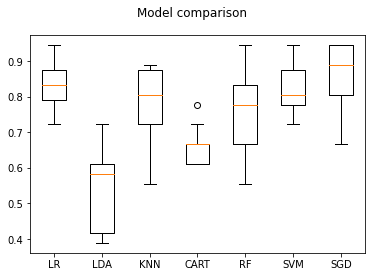

In [0]:
# fixed-sizes for image
fixed_size = tuple((256, 256))
# number of trees for Random Forests
num_trees = 100
# train_test_split size and seef for repetation
test_size = 0.25
seed = 42
# create all the machine learning models
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('SVM', SVC(random_state=seed)))
models.append(("SGD", SGDClassifier(random_state=seed, max_iter=1000, tol=1e-3)))

# variables to hold the results and names
results = []
names = []
scoring = "accuracy"

# import the feature vector and trained labels
h5f_data = h5py.File('/content/drive/My Drive/Colab Notebooks/ComputerVision/Notebooks/Individual Assignment/output/data.h5', 'r')
h5f_label = h5py.File('/content/drive/My Drive/Colab Notebooks/ComputerVision/Notebooks/Individual Assignment/output/labels.h5', 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of the feature vector and labels
print("[STATUS] features shape: {}".format(global_features.shape))
print("[STATUS] labels shape: {}".format(global_labels.shape))
print("[STATUS] training started...")

# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)
print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape))
print("Train labels: {}".format(trainLabelsGlobal.shape))
print("Test labels : {}".format(testLabelsGlobal.shape))

# filter all the warnings
import warnings
warnings.filterwarnings('ignore')

# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Model comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()


As seen above, Support Vector Machine has given the best performance among others.

## Testing our best classifier on new images


2


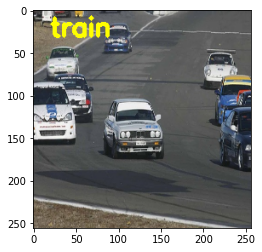

2


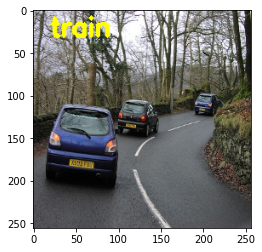

2


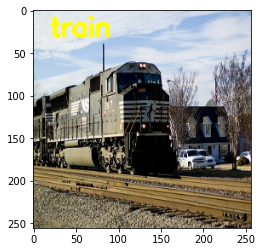

2


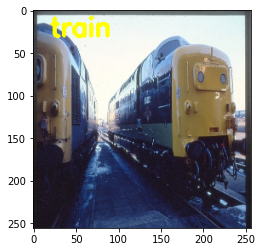

2


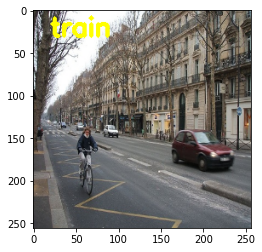

2


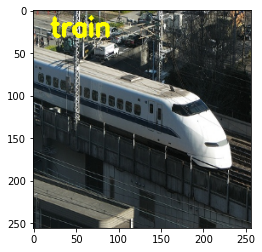

2


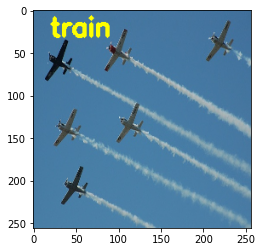

2


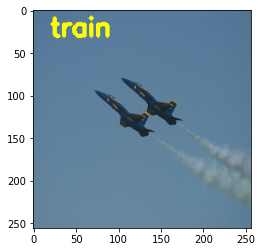

2


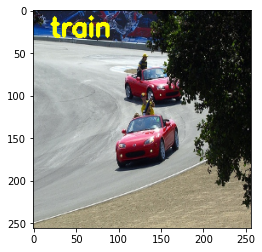

2


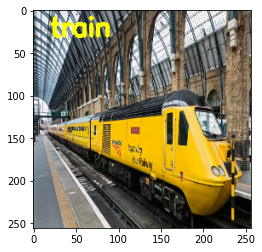

2


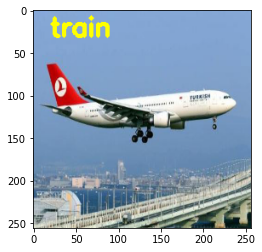

In [0]:
# create the model - Stochastic Gradient Descent
clf  = SGDClassifier(random_state=seed, max_iter=1000, tol=1e-3)

# fit the training data to the model
clf.fit(trainDataGlobal, trainLabelsGlobal)

# path to test data
test_path = "/content/drive/My Drive/Colab Notebooks/ComputerVision/Notebooks/Individual Assignment/data/object_detection"

# loop through the test images
for file in glob.glob(test_path + "/*.jpg"):
    # read the image
    image = cv2.imread(file)

    # resize the image
    image = cv2.resize(image, fixed_size)

    # Concatenate global features
    global_feature = np.hstack([fd_histogram(image), fd_haralick(image), fd_hu_moments(image)])

    # predict label of test image
    prediction = clf.predict(global_feature.reshape(1,-1))[0]
    print(prediction)

    # show predicted label on image
    cv2.putText(image, train_labels[prediction], (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)

    # display the output image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

Ooops! This is showing an obvious case of overfitting. This variation is likely to be resulted from the size of dataset. <br><br> Now we will try `RandomForestClassifier` which is more promising in such circumstances. 


0


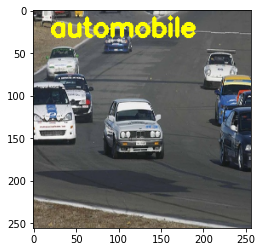

0


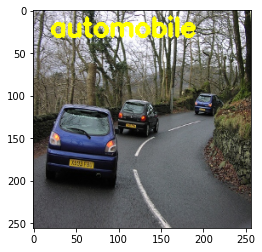

2


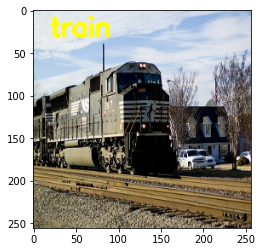

2


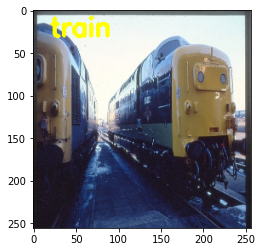

2


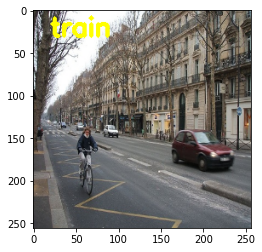

0


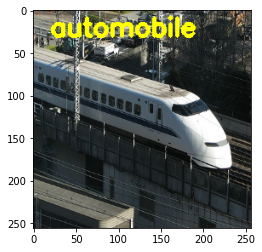

1


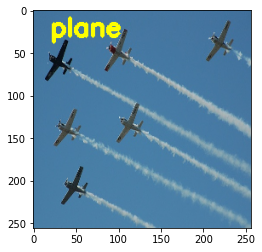

1


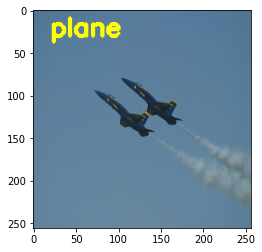

0


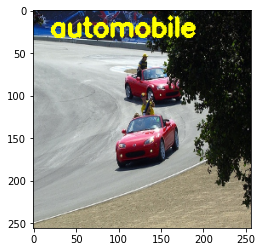

2


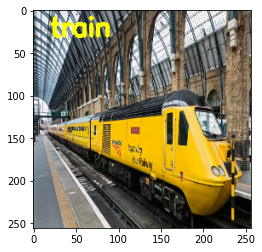

1


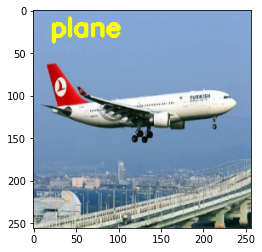

In [0]:
# create the model - Random Forest
clf  = RandomForestClassifier(n_estimators=num_trees, random_state=seed)

# fit the training data to the model
clf.fit(trainDataGlobal, trainLabelsGlobal)

# path to test data
test_path = "/content/drive/My Drive/Colab Notebooks/ComputerVision/Notebooks/Individual Assignment/data/object_detection"

# loop through the test images
for file in glob.glob(test_path + "/*.jpg"):
    # read the image
    image = cv2.imread(file)    
    # resize the image
    image = cv2.resize(image, fixed_size)

    # Concatenate global features
    global_feature = np.hstack([fd_histogram(image), fd_haralick(image), fd_hu_moments(image)])

    # predict label of test image
    prediction = clf.predict(global_feature.reshape(1,-1))[0]
    print(prediction)

    # show predicted label on image
    cv2.putText(image, train_labels[prediction], (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)

    # display the output image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

RandomForest finally rendered us quite acceptable result by labeling 9 correct out of 11 images! <br>
Normally, higher accuracies could even be accomplished even though we are way better than initial attempt. This is more because of the limited size of our training dataset. Other classifiers such as SVG, Decision Tree would yield remarkable results if we have more images to train.

## Conclusion

In this assignment, I visited image classification techniques playing around feature extraction methods in addition to class materials. <br>
This study underlines the preprocessing techniques and towards final, models trained bear huge possibility of overfitting. Even though K-fold cross validation is applied, accuracy rendered per model needs still further elaboration as seen incorrect labels on new dataset. <br>
Although **image segmentation** is used as a preliminary step for image classification, here it yielded worse result.
Checking the final accuracies another feature I decided to cancel out is Canny Edge detector, most probably due to overfitting.<br><br> All in all, to achieve better scores are possible along; `local features` such as SIFT, SURF, ORG; `PCA` dimension reduction for feature extraction, `Data Augmentation` or ideally `a more abundant dataset` and if so, `CNN` which is the state-of-art.


## Acknowledgments and References



*   [The Canny Edge Detector for Feature Extraction](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.469.7794&rep=rep1&type=pdf)
*   [HoG](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html)
*   [Classification with Scikit-Learn](https://gogul.dev/software/image-classification-python)
*   [Image Segmentation](https://www.analyticsvidhya.com/blog/2019/04/introduction-image-segmentation-techniques-python/)





*Arif Can Aksoy - MBD2*